In [3]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
import pymc as pm
import arviz as az 


https://www.pymc.io/projects/examples/en/latest/mixture_models/dp_mix.html

In [5]:
import pytensor.tensor as pt

## Week 12 Homework (10)

### Q1: define 

- Gaussian Processes (GPs) and stochastic processes generally
- Variational inference using the Evidence Lower Bound (ELBO)

### Q2: more GPs

Repurpose PyMC documentation to provide a demonstration of Gaussian processes for a different dataset context than the PyMC examples.

### Q3: more VI/ELBO

Repurpose PyMC documentation to provide a demonstration of a neural network fit with variational inference for a different dataset context than the PyMC examples.



# Q1
### (1)
Gaussian Processes (GPs) and Stochastic Processes:
A stochastic process is a collection of random variables indexed by time or space, where each random variable represents the state of a system at a particular point. It is a mathematical object used to model systems that evolve with uncertainty. A Gaussian Process (GP) is a specific type of stochastic process where any finite collection of those random variables has a joint multivariate Gaussian distribution. GPs are fully specified by a mean function and a covariance (kernel) function, which determine the expected value and the correlation between function values at different points. In machine learning, Gaussian Processes are used for non-parametric regression and classification, offering flexible modeling with principled uncertainty estimates. They are particularly powerful because they can model functions directly without assuming a fixed functional form.
### (2)
Variational Inference and the Evidence Lower Bound (ELBO):
Variational Inference (VI) is a technique used to approximate complex posterior distributions in Bayesian models when exact inference is computationally intractable. The core idea is to choose a family of simpler distributions and then find the member of that family that is closest to the true posterior, typically by minimizing the Kullback–Leibler (KL) divergence between them. This optimization is done by maximizing the Evidence Lower Bound (ELBO), which serves as a lower bound on the model's log marginal likelihood. The ELBO balances model fit (how well the approximation explains the data) with complexity (how far the approximation deviates from the prior). Maximizing the ELBO provides an efficient, scalable way to perform approximate Bayesian inference in complex models, including those used in deep learning and probabilistic programming.

# Q2

### Gaussian Process Example with a Custom Dataset

In this demonstration, we repurpose PyMC documentation to show how to set up and fit a Gaussian Process (GP) model on a different dataset context than the standard PyMC examples. Specifically, we will generate synthetic data from a function (e.g., a combination of sine waves and noise) and then use PyMC’s Gaussian Process capabilities to fit and predict.

**Key Steps**:

1. **Data Generation**  
   We create data points $( x $) uniformly over a chosen range and generate $( y $) using a function such as $( y = \sin(2x) + \cos(0.5x) $) plus random noise. This produces a wavy pattern in the response variable.

2. **Model Specification**  
   - We define a mean function (often taken as zero or a simple constant) and a covariance function (kernel).  
   - In PyMC, we can create a GP by importing `pymc as pm` and using `pm.gp.Marginal` (or `pm.gp.Latent` if we want to explicitly infer latent function values).
   - The kernel choice influences how smooth or wiggly the GP can be. In this example, we use a Matérn 3/2 kernel.

3. **Fitting the Model**  
   We define the likelihood of observations, often assumed Gaussian with a certain noise variance. Then, we sample from the posterior distribution of the GP hyperparameters (e.g., length scale, variance).

4. **Posterior Predictive Checks**  
   After sampling, we can generate posterior predictive distributions over new $( x $) values. This allows us to visualize how well the GP captures the underlying function and the associated uncertainty.

/opt/conda/lib/python3.11/site-packages/pymc/gp/gp.py:56: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [length_scale, η, sigma]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 53 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [f_pred]


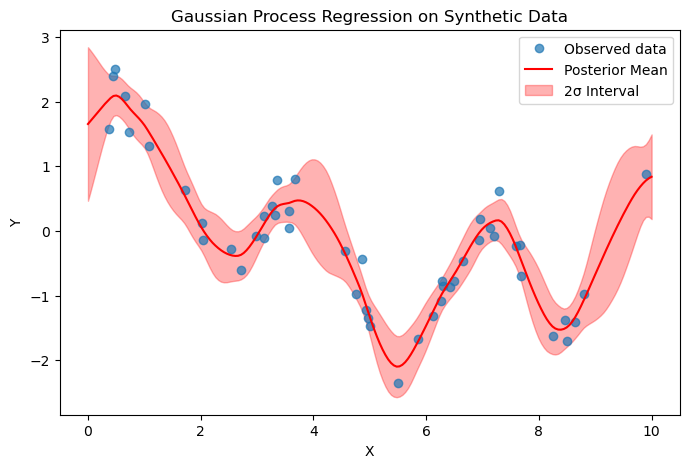

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
length_scale,1.257,0.322,0.712,1.882,0.010,0.007,988.0,1241.0,1.0
η,1.217,0.288,0.729,1.763,0.009,0.008,1017.0,1064.0,1.0
sigma,0.286,0.037,0.222,0.354,0.001,0.001,1350.0,1321.0,1.0


In [9]:
# Q2
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# ----- Step 1: Generate Synthetic Data -----
rng = np.random.default_rng(365)  # for reproducibility
X = rng.uniform(0, 10, 50)       # 50 data points in [0, 10]
f_true = np.sin(2*X) + np.cos(0.5*X)
noise = rng.normal(0, 0.3, size=50)
Y = f_true + noise

# Sort data for plotting (not strictly necessary, but often helps visualize)
sort_idx = np.argsort(X)
X_sorted = X[sort_idx]
Y_sorted = Y[sort_idx]

# Reshape X for PyMC (GPs often expect 2D array for inputs)
X_reshaped = X[:, None]

# ----- Step 2: Define and Fit the GP Model -----
with pm.Model() as gp_model:
    
    # Hyperpriors for the covariance function
    length_scale = pm.HalfNormal("length_scale", sigma=1)
    η = pm.HalfNormal("η", sigma=1)  # amplitude or variance parameter
    
    # Covariance function: Matern 3/2 kernel
    cov_function = η**2 * pm.gp.cov.Matern32(1, length_scale)
    
    # GP Marginal
    gp = pm.gp.Marginal(cov_func=cov_function)
    
    # Noise term
    sigma = pm.HalfCauchy("sigma", beta=1)
    
    # Define the likelihood
    y_obs = gp.marginal_likelihood("y_obs", X=X_reshaped, y=Y, noise=sigma)
    
    # Sample from the posterior
    trace = pm.sample(1000, tune=1000, chains=2, random_seed=365, target_accept=0.95)

# ----- Step 3: Posterior Predictive Sampling -----
X_new = np.linspace(0, 10, 200)[:, None]

with gp_model:
    # Define predictive conditional
    f_pred = gp.conditional("f_pred", X_new)
    
    # Sample from posterior predictive including f_pred
    posterior_pred = pm.sample_posterior_predictive(
        trace, 
        var_names=["f_pred"], 
        random_seed=365
    )

# Extract mean and std across (chain, draw) dimensions
# posterior_pred is an InferenceData object
f_pred_samples = posterior_pred.posterior_predictive["f_pred"].stack(sample=("chain", "draw")).values
f_pred_mean = f_pred_samples.mean(axis=1)
f_pred_std = f_pred_samples.std(axis=1)

# ----- Step 4: Visualize Results -----
plt.figure(figsize=(8, 5))
plt.plot(X_sorted, Y_sorted, "o", label="Observed data", alpha=0.7)
plt.plot(X_new, f_pred_mean, "r", label="Posterior Mean")
plt.fill_between(
    X_new.flatten(),
    f_pred_mean - 2 * f_pred_std,
    f_pred_mean + 2 * f_pred_std,
    color="red",
    alpha=0.3,
    label="2σ Interval"
)
plt.title("Gaussian Process Regression on Synthetic Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

# Summarize the trace
az.summary(trace, var_names=["length_scale", "η", "sigma"])

# Q3

### Bayesian Neural Network with Variational Inference (Iris Dataset)

This example demonstrates how to perform variational inference on a Bayesian neural network using PyMC, repurposing the methodology from PyMC’s examples but applying it to the well-known **Iris** classification dataset. 

Bayesian neural networks can capture uncertainty in the weight parameters. Instead of learning a single weight for each connection, we learn a *distribution* over possible weights. We will use **Automatic Differentiation Variational Inference** (ADVI) to approximate the posterior distribution of the network weights.

## Key Steps

1. **Data Loading**  
   We load the Iris dataset, which contains 150 samples of flowers from three species, each with four features: sepal length, sepal width, petal length, and petal width. Our task is to predict the species given these features.

2. **Neural Network Architecture**  
   - We define a one-hidden-layer neural network with a chosen size (e.g., 5 hidden units).  
   - Each weight and bias is assigned a prior distribution (often a Normal(0,1) or similar).  

3. **Variational Inference**  
   - We use ADVI (Automatic Differentiation Variational Inference) to approximate the posterior over weights.  
   - ADVI transforms the problem into an optimization: we minimize the Evidence Lower Bound (ELBO) to fit the variational parameters.

4. **Inference and Evaluation**  
   - After convergence of ADVI, we retrieve samples from the approximate posterior.  
   - We can then evaluate how well the model performs on held-out test data or directly measure classification accuracy on the training set.  

The code that implements these steps in PyMC for the Iris dataset will be shown.


Finished [100%]: Average Loss = 300.52


ArviZ Summary of Posterior:


arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
w_in_1[0, 0]  -0.010  0.270  -0.489    0.514      0.008    0.006    1105.0   
w_in_1[0, 1]  -0.011  0.271  -0.496    0.507      0.008    0.007    1038.0   
w_in_1[0, 2]   0.010  0.265  -0.472    0.498      0.008    0.006    1001.0   
w_in_1[0, 3]  -0.008  0.266  -0.511    0.445      0.008    0.006    1054.0   
w_in_1[0, 4]  -0.012  0.272  -0.509    0.521      0.011    0.007     644.0   
w_in_1[1, 0]  -0.008  0.271  -0.498    0.522      0.010    0.006     734.0   
w_in_1[1, 1]   0.001  0.271  -0.510    0.487      0.010    0.006     787.0   
w_in_1[1, 2]   0.009  0.263  -0.489    0.462      0.009    0.006     953.0   
w_in_1[1, 3]   0.008  0.267  -0.478    0.533      0.008    0.006    1128.0   
w_in_1[1, 4]   0.007  0.267  -0.519    0.510      0.009    0.006     869.0   
w_in_1[2, 0]  -0.004  0.267  -0.553    0.437      0.008    0.006    1056.0   
w_in_1[2, 1]  -0.004  0.270  -0.503    0.526      0.009    0.006

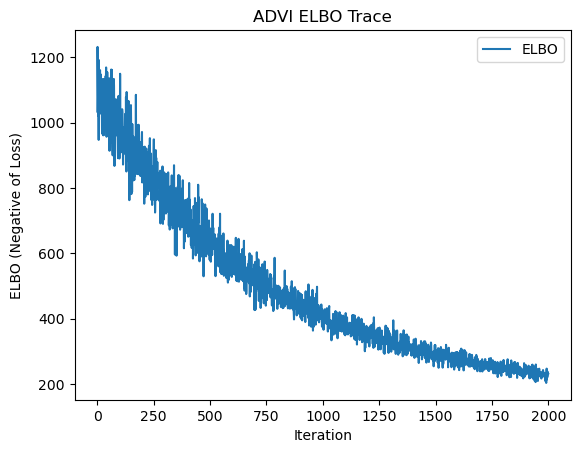

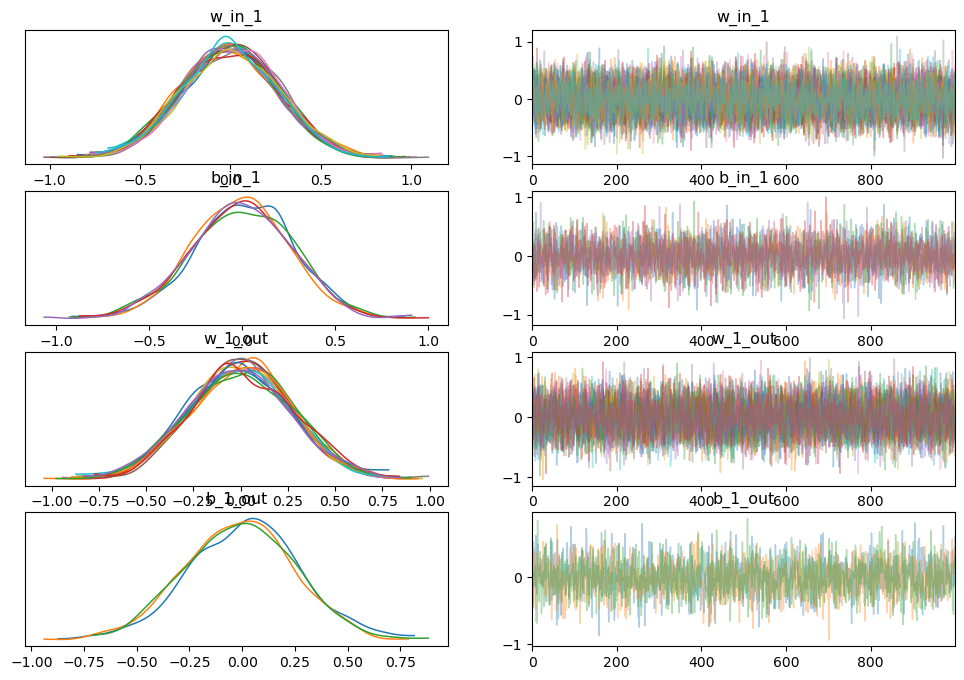

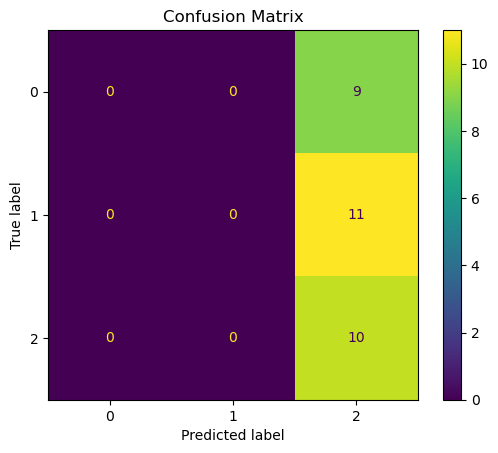

In [3]:
# Q3
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from pymc.math import softmax
import arviz as az
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# -------------------------------
# Step 1: Load and Prepare the Data
# -------------------------------
iris = load_iris()
X = iris.data
y = iris.target

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Encode labels as integers
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=365
)

n_features = X_train.shape[1]        # 4 features in Iris
n_hidden = 5                         # hidden layer size
n_classes = len(np.unique(y_train))  # 3 classes in Iris

# -------------------------------
# Step 2: Define Bayesian Neural Network Model
# -------------------------------
with pm.Model() as bnn_model:
    
    # Mutable data so we can switch between train and test sets later
    X_shared = pm.MutableData("X_shared", X_train)
    y_shared = pm.MutableData("y_shared", y_train)

    # Define priors for weights and biases (smaller sigma to stabilize training)
    w_in_1 = pm.Normal("w_in_1", mu=0.0, sigma=0.1, shape=(n_features, n_hidden))
    b_in_1 = pm.Normal("b_in_1", mu=0.0, sigma=0.1, shape=(n_hidden,))

    w_1_out = pm.Normal("w_1_out", mu=0.0, sigma=0.1, shape=(n_hidden, n_classes))
    b_1_out = pm.Normal("b_1_out", mu=0.0, sigma=0.1, shape=(n_classes,))

    # Forward pass: hidden layer with tanh activation
    hidden = pt.tanh(pt.dot(X_shared, w_in_1) + b_in_1)  # shape: (batch_size, n_hidden)

    # Output logits
    logits = pt.dot(hidden, w_1_out) + b_1_out          # shape: (batch_size, n_classes)

    # Apply softmax along the last axis to get class probabilities
    # Explicitly specify axis=-1 (i.e., the last dimension) to ensure we get shape (batch_size, n_classes)
    y_hat = softmax(logits, axis=-1)                    # shape: (batch_size, n_classes)

    # Clip probabilities slightly to avoid numerical issues with log(0)
    y_hat_clipped = pm.math.clip(y_hat, 1e-4, 1 - 1e-4)

    # Likelihood (Categorical) for multi-class classification
    pm.Categorical("obs", p=y_hat_clipped, observed=y_shared)

# -------------------------------
# Step 3: Fit the Model with ADVI
# -------------------------------
with bnn_model:
    approx = pm.fit(
        n=2000,                               # number of ADVI iterations
        method="advi",
        callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)],
        obj_optimizer=pm.adam(learning_rate=0.001),  # smaller learning rate
        obj_n_mc=10                                    # more MC samples per iteration
    )

# -------------------------------
# Step 4: Draw Samples from the Posterior
# -------------------------------
with bnn_model:
    posterior_samples = approx.sample(draws=1000)

# -------------------------------
# Step 5: Examine the Posterior
# -------------------------------
print("ArviZ Summary of Posterior:")
summary = az.summary(
    posterior_samples,
    var_names=["w_in_1", "b_in_1", "w_1_out", "b_1_out"]
)
print(summary)

# -------------------------------
# Step 6: Prediction on Test Data
# -------------------------------
with bnn_model:
    # Replace training data with test data in the shared variables
    pm.set_data({"X_shared": X_test})
    
    # Symbolic expression for predictions (softmax across the last dimension)
    pred_expr = softmax(
        pt.dot(pt.tanh(pt.dot(X_shared, w_in_1) + b_in_1), w_1_out) + b_1_out,
        axis=-1
    )
    
    # Compile a callable function for forward pass
    predict_fn = pm.compile_pymc([], pred_expr)

# Evaluate predictions
pred_probs = predict_fn()                        # shape: (num_test_samples, n_classes)
pred_labels = np.argmax(pred_probs, axis=1)      # pick the class with highest probability
accuracy = np.mean(pred_labels == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# -------------------------------
# Step 7: Plotting and Diagnostics
# -------------------------------
# (1) ADVI ELBO History
advi_elbo = pd.DataFrame({"ELBO": approx.hist})
advi_elbo.plot()
plt.title("ADVI ELBO Trace")
plt.xlabel("Iteration")
plt.ylabel("ELBO (Negative of Loss)")
plt.show()

# (2) Posterior Traces for Selected Parameters
az.plot_trace(posterior_samples, var_names=["w_in_1", "b_in_1", "w_1_out", "b_1_out"])
plt.show()

# (3) Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix")
plt.show()